## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:

import os
import keras

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
import os
import keras


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:

"""Code Here
建立你的神經網路
"""
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.99, 0.5, 0.1]
redice_lr_patient = [3,5,8]

In [10]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.99, reduce_patient: 3
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
b

49/49 [==============================] - 1s 11ms/step - loss: 1.2618 - accuracy: 0.5602 - val_loss: 1.4822 - val_accuracy: 0.4765
Epoch 14/25
49/49 [==============================] - 1s 11ms/step - loss: 1.2483 - accuracy: 0.5685 - val_loss: 1.4845 - val_accuracy: 0.4743
Epoch 15/25
49/49 [==============================] - 1s 11ms/step - loss: 1.2169 - accuracy: 0.5761 - val_loss: 1.4766 - val_accuracy: 0.4754
Epoch 16/25
49/49 [==============================] - 1s 11ms/step - loss: 1.2030 - accuracy: 0.5834 - val_loss: 1.4747 - val_accuracy: 0.4789
Epoch 17/25
49/49 [==============================] - 1s 11ms/step - loss: 1.1806 - accuracy: 0.5918 - val_loss: 1.4636 - val_accuracy: 0.4841
Epoch 18/25
49/49 [==============================] - 1s 11ms/step - loss: 1.1619 - accuracy: 0.6031 - val_loss: 1.4587 - val_accuracy: 0.4837
Epoch 19/25
49/49 [==============================] - 1s 11ms/step - loss: 1.1338 - accuracy: 0.6100 - val_loss: 1.4654 - val_accuracy: 0.4848
Epoch 20/25
49/49 

Epoch 1/25
49/49 [==============================] - 1s 14ms/step - loss: 2.5370 - accuracy: 0.1910 - val_loss: 2.1719 - val_accuracy: 0.1699
Epoch 2/25
49/49 [==============================] - 1s 10ms/step - loss: 1.8079 - accuracy: 0.3731 - val_loss: 2.0058 - val_accuracy: 0.2909
Epoch 3/25
49/49 [==============================] - 1s 10ms/step - loss: 1.6539 - accuracy: 0.4194 - val_loss: 1.8369 - val_accuracy: 0.3681
Epoch 4/25
49/49 [==============================] - 1s 11ms/step - loss: 1.5743 - accuracy: 0.4492 - val_loss: 1.7177 - val_accuracy: 0.4022
Epoch 5/25
49/49 [==============================] - 1s 11ms/step - loss: 1.5217 - accuracy: 0.4662 - val_loss: 1.6405 - val_accuracy: 0.4230
Epoch 6/25
49/49 [==============================] - 1s 11ms/step - loss: 1.4728 - accuracy: 0.4852 - val_loss: 1.5970 - val_accuracy: 0.4334
Epoch 7/25
49/49 [==============================] - 1s 10ms/step - loss: 1.4327 - accuracy: 0.4992 - val_loss: 1.5540 - val_accuracy: 0.4471
Epoch 8/25
49

Epoch 23/25
49/49 [==============================] - 0s 10ms/step - loss: 1.2389 - accuracy: 0.5711 - val_loss: 1.4950 - val_accuracy: 0.4770
Epoch 24/25
49/49 [==============================] - 1s 11ms/step - loss: 1.2273 - accuracy: 0.5781 - val_loss: 1.4864 - val_accuracy: 0.4783
Epoch 25/25
49/49 [==============================] - 1s 10ms/step - loss: 1.2104 - accuracy: 0.5839 - val_loss: 1.4840 - val_accuracy: 0.4810
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 8
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_18 (Batc (None, 256)               1024      
_____________________________________

49/49 [==============================] - 1s 11ms/step - loss: 1.4655 - accuracy: 0.4844 - val_loss: 1.5719 - val_accuracy: 0.4496
Epoch 11/25
49/49 [==============================] - 1s 11ms/step - loss: 1.4378 - accuracy: 0.4966 - val_loss: 1.5604 - val_accuracy: 0.4524
Epoch 12/25
49/49 [==============================] - 1s 12ms/step - loss: 1.4193 - accuracy: 0.5035 - val_loss: 1.5494 - val_accuracy: 0.4559
Epoch 13/25
49/49 [==============================] - 1s 11ms/step - loss: 1.4016 - accuracy: 0.5096 - val_loss: 1.5410 - val_accuracy: 0.4557
Epoch 14/25
49/49 [==============================] - 1s 12ms/step - loss: 1.3784 - accuracy: 0.5220 - val_loss: 1.5317 - val_accuracy: 0.4647
Epoch 15/25
49/49 [==============================] - 1s 11ms/step - loss: 1.3646 - accuracy: 0.5216 - val_loss: 1.5199 - val_accuracy: 0.4695
Epoch 16/25
49/49 [==============================] - 1s 12ms/step - loss: 1.3415 - accuracy: 0.5325 - val_loss: 1.5132 - val_accuracy: 0.4695
Epoch 17/25
49/49 

Epoch 1/25
49/49 [==============================] - 1s 14ms/step - loss: 2.7082 - accuracy: 0.1606 - val_loss: 2.1758 - val_accuracy: 0.2277
Epoch 2/25
49/49 [==============================] - 1s 11ms/step - loss: 1.9484 - accuracy: 0.3297 - val_loss: 2.0454 - val_accuracy: 0.2769
Epoch 3/25
49/49 [==============================] - 1s 10ms/step - loss: 1.7800 - accuracy: 0.3807 - val_loss: 1.9034 - val_accuracy: 0.3366
Epoch 4/25
49/49 [==============================] - 1s 11ms/step - loss: 1.6867 - accuracy: 0.4075 - val_loss: 1.7955 - val_accuracy: 0.3713
Epoch 5/25
49/49 [==============================] - 1s 10ms/step - loss: 1.6329 - accuracy: 0.4256 - val_loss: 1.7052 - val_accuracy: 0.3994
Epoch 6/25
49/49 [==============================] - 1s 11ms/step - loss: 1.5861 - accuracy: 0.4447 - val_loss: 1.6553 - val_accuracy: 0.4125
Epoch 7/25
49/49 [==============================] - 1s 10ms/step - loss: 1.5524 - accuracy: 0.4555 - val_loss: 1.6213 - val_accuracy: 0.4227
Epoch 8/25
49

49/49 [==============================] - 1s 11ms/step - loss: 0.5063 - accuracy: 0.8325 - val_loss: 1.9489 - val_accuracy: 0.4502

Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.0009509901772253215.
Epoch 22/25
49/49 [==============================] - 1s 10ms/step - loss: 0.4808 - accuracy: 0.8411 - val_loss: 2.1814 - val_accuracy: 0.4426
Epoch 23/25
49/49 [==============================] - 1s 11ms/step - loss: 0.4360 - accuracy: 0.8585 - val_loss: 1.8673 - val_accuracy: 0.4894
Epoch 24/25
49/49 [==============================] - 1s 11ms/step - loss: 0.4000 - accuracy: 0.8734 - val_loss: 2.6338 - val_accuracy: 0.3867

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.0009414802846731617.
Epoch 25/25
49/49 [==============================] - 1s 11ms/step - loss: 0.3870 - accuracy: 0.8762 - val_loss: 2.1216 - val_accuracy: 0.4425
Numbers of exp: 10, reduce_factor: 0.99, reduce_patient: 5
Model: "model_11"
_______________________________________________________________

Epoch 6/25
49/49 [==============================] - 1s 11ms/step - loss: 1.2901 - accuracy: 0.5412 - val_loss: 1.6395 - val_accuracy: 0.4121
Epoch 7/25
49/49 [==============================] - 1s 11ms/step - loss: 1.2428 - accuracy: 0.5603 - val_loss: 1.4511 - val_accuracy: 0.4825
Epoch 8/25
49/49 [==============================] - 1s 11ms/step - loss: 1.1904 - accuracy: 0.5783 - val_loss: 1.4730 - val_accuracy: 0.4736
Epoch 9/25
49/49 [==============================] - 1s 11ms/step - loss: 1.1525 - accuracy: 0.5887 - val_loss: 1.5204 - val_accuracy: 0.4579
Epoch 10/25
49/49 [==============================] - 1s 11ms/step - loss: 1.1042 - accuracy: 0.6083 - val_loss: 1.5794 - val_accuracy: 0.4568
Epoch 11/25
49/49 [==============================] - 1s 11ms/step - loss: 1.0644 - accuracy: 0.6230 - val_loss: 1.5832 - val_accuracy: 0.4531
Epoch 12/25
49/49 [==============================] - 1s 11ms/step - loss: 1.0308 - accuracy: 0.6371 - val_loss: 1.5110 - val_accuracy: 0.4659
Epoch 13/2

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_42 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_43 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_44 (Batc (None, 256)               102

49/49 [==============================] - 1s 11ms/step - loss: 1.2641 - accuracy: 0.5650 - val_loss: 1.4780 - val_accuracy: 0.4803
Epoch 13/25
49/49 [==============================] - 1s 10ms/step - loss: 1.2447 - accuracy: 0.5709 - val_loss: 1.4789 - val_accuracy: 0.4793
Epoch 14/25
49/49 [==============================] - 1s 11ms/step - loss: 1.2320 - accuracy: 0.5768 - val_loss: 1.4714 - val_accuracy: 0.4795
Epoch 15/25
49/49 [==============================] - 1s 11ms/step - loss: 1.2173 - accuracy: 0.5815 - val_loss: 1.4691 - val_accuracy: 0.4849
Epoch 16/25
49/49 [==============================] - 1s 11ms/step - loss: 1.1955 - accuracy: 0.5904 - val_loss: 1.4671 - val_accuracy: 0.4859
Epoch 17/25
49/49 [==============================] - 1s 10ms/step - loss: 1.1811 - accuracy: 0.5980 - val_loss: 1.4534 - val_accuracy: 0.4881
Epoch 18/25
49/49 [==============================] - 1s 11ms/step - loss: 1.1690 - accuracy: 0.6017 - val_loss: 1.4569 - val_accuracy: 0.4904
Epoch 19/25
49/49 

Epoch 1/25
49/49 [==============================] - 2s 15ms/step - loss: 2.7563 - accuracy: 0.1547 - val_loss: 2.2109 - val_accuracy: 0.1774
Epoch 2/25
49/49 [==============================] - 1s 11ms/step - loss: 2.2267 - accuracy: 0.2651 - val_loss: 2.1219 - val_accuracy: 0.2387
Epoch 3/25
49/49 [==============================] - 1s 11ms/step - loss: 2.0804 - accuracy: 0.2975 - val_loss: 2.0361 - val_accuracy: 0.2725
Epoch 4/25
49/49 [==============================] - 1s 11ms/step - loss: 2.0000 - accuracy: 0.3182 - val_loss: 1.9653 - val_accuracy: 0.2941
Epoch 5/25
49/49 [==============================] - 1s 11ms/step - loss: 1.9444 - accuracy: 0.3364 - val_loss: 1.9151 - val_accuracy: 0.3101
Epoch 6/25
49/49 [==============================] - 1s 11ms/step - loss: 1.9254 - accuracy: 0.3405 - val_loss: 1.8811 - val_accuracy: 0.3285
Epoch 7/25
49/49 [==============================] - 1s 10ms/step - loss: 1.8801 - accuracy: 0.3554 - val_loss: 1.8615 - val_accuracy: 0.3376
Epoch 8/25
49

49/49 [==============================] - 1s 10ms/step - loss: 1.6997 - accuracy: 0.4096 - val_loss: 1.7711 - val_accuracy: 0.3891
Epoch 24/25
49/49 [==============================] - 1s 11ms/step - loss: 1.6848 - accuracy: 0.4132 - val_loss: 1.7658 - val_accuracy: 0.3881
Epoch 25/25
49/49 [==============================] - 1s 10ms/step - loss: 1.6776 - accuracy: 0.4150 - val_loss: 1.7611 - val_accuracy: 0.3913
Numbers of exp: 18, reduce_factor: 0.99, reduce_patient: 3
Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_57 (Batc (None, 256)               1024      
_______________________________________________

Epoch 8/25
49/49 [==============================] - 1s 12ms/step - loss: 1.1103 - accuracy: 0.6072 - val_loss: 1.7147 - val_accuracy: 0.4037
Epoch 9/25
49/49 [==============================] - 1s 12ms/step - loss: 1.0620 - accuracy: 0.6286 - val_loss: 1.6606 - val_accuracy: 0.4253
Epoch 10/25
49/49 [==============================] - 1s 13ms/step - loss: 1.0296 - accuracy: 0.6356 - val_loss: 1.7335 - val_accuracy: 0.4119
Epoch 11/25
49/49 [==============================] - 1s 12ms/step - loss: 0.9905 - accuracy: 0.6515 - val_loss: 1.6763 - val_accuracy: 0.4298

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0009509901772253215.
Epoch 12/25
49/49 [==============================] - 1s 13ms/step - loss: 0.9535 - accuracy: 0.6675 - val_loss: 1.9497 - val_accuracy: 0.3846
Epoch 13/25
49/49 [==============================] - 1s 12ms/step - loss: 0.9111 - accuracy: 0.6804 - val_loss: 1.7717 - val_accuracy: 0.4275
Epoch 14/25
49/49 [==============================] - 1s 13ms/step - l

Epoch 1/25
49/49 [==============================] - 2s 16ms/step - loss: 2.1035 - accuracy: 0.3058 - val_loss: 2.7374 - val_accuracy: 0.1323
Epoch 2/25
49/49 [==============================] - 1s 12ms/step - loss: 1.5488 - accuracy: 0.4563 - val_loss: 1.9744 - val_accuracy: 0.2931
Epoch 3/25
49/49 [==============================] - ETA: 0s - loss: 1.4288 - accuracy: 0.49 - 1s 12ms/step - loss: 1.4284 - accuracy: 0.4978 - val_loss: 2.0808 - val_accuracy: 0.2962
Epoch 4/25
49/49 [==============================] - 1s 13ms/step - loss: 1.3419 - accuracy: 0.5262 - val_loss: 1.9103 - val_accuracy: 0.3408
Epoch 5/25
49/49 [==============================] - 1s 12ms/step - loss: 1.2630 - accuracy: 0.5540 - val_loss: 1.8392 - val_accuracy: 0.3659
Epoch 6/25
49/49 [==============================] - 1s 12ms/step - loss: 1.2289 - accuracy: 0.5691 - val_loss: 1.7814 - val_accuracy: 0.3798
Epoch 7/25
49/49 [==============================] - 1s 12ms/step - loss: 1.1748 - accuracy: 0.5874 - val_loss: 1

Epoch 21/25
49/49 [==============================] - 1s 12ms/step - loss: 1.0896 - accuracy: 0.6291 - val_loss: 1.4907 - val_accuracy: 0.4838
Epoch 22/25
49/49 [==============================] - 1s 12ms/step - loss: 1.0734 - accuracy: 0.6356 - val_loss: 1.4649 - val_accuracy: 0.4909
Epoch 23/25
49/49 [==============================] - 1s 12ms/step - loss: 1.0645 - accuracy: 0.6399 - val_loss: 1.4711 - val_accuracy: 0.4859
Epoch 24/25
49/49 [==============================] - 1s 13ms/step - loss: 1.0459 - accuracy: 0.6475 - val_loss: 1.4587 - val_accuracy: 0.4879
Epoch 25/25
49/49 [==============================] - 1s 12ms/step - loss: 1.0166 - accuracy: 0.6557 - val_loss: 1.4841 - val_accuracy: 0.4903
Numbers of exp: 23, reduce_factor: 0.50, reduce_patient: 8
Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 3072)]            0         
_______________

49/49 [==============================] - 1s 13ms/step - loss: 1.3965 - accuracy: 0.5138 - val_loss: 1.5486 - val_accuracy: 0.4577
Epoch 9/25
49/49 [==============================] - 1s 12ms/step - loss: 1.3542 - accuracy: 0.5300 - val_loss: 1.5695 - val_accuracy: 0.4479
Epoch 10/25
49/49 [==============================] - 1s 13ms/step - loss: 1.3276 - accuracy: 0.5379 - val_loss: 1.5450 - val_accuracy: 0.4548
Epoch 11/25
49/49 [==============================] - 1s 12ms/step - loss: 1.3038 - accuracy: 0.5487 - val_loss: 1.4995 - val_accuracy: 0.4754
Epoch 12/25
49/49 [==============================] - 1s 12ms/step - loss: 1.2694 - accuracy: 0.5588 - val_loss: 1.5263 - val_accuracy: 0.4622
Epoch 13/25
49/49 [==============================] - 1s 12ms/step - loss: 1.2507 - accuracy: 0.5663 - val_loss: 1.4974 - val_accuracy: 0.4778
Epoch 14/25
49/49 [==============================] - 1s 12ms/step - loss: 1.2249 - accuracy: 0.5743 - val_loss: 1.5038 - val_accuracy: 0.4773
Epoch 15/25
49/49 [

Epoch 1/25
49/49 [==============================] - 2s 16ms/step - loss: 2.8384 - accuracy: 0.1149 - val_loss: 2.2777 - val_accuracy: 0.1240
Epoch 2/25
49/49 [==============================] - 1s 12ms/step - loss: 2.4795 - accuracy: 0.1870 - val_loss: 2.2167 - val_accuracy: 0.1687
Epoch 3/25
49/49 [==============================] - 1s 12ms/step - loss: 2.3003 - accuracy: 0.2328 - val_loss: 2.1378 - val_accuracy: 0.2181
Epoch 4/25
49/49 [==============================] - 1s 12ms/step - loss: 2.1819 - accuracy: 0.2628 - val_loss: 2.0629 - val_accuracy: 0.2572
Epoch 5/25
49/49 [==============================] - 1s 12ms/step - loss: 2.0934 - accuracy: 0.2914 - val_loss: 1.9975 - val_accuracy: 0.2851
Epoch 6/25
49/49 [==============================] - 1s 12ms/step - loss: 2.0274 - accuracy: 0.3090 - val_loss: 1.9520 - val_accuracy: 0.3098
Epoch 7/25
49/49 [==============================] - 1s 12ms/step - loss: 1.9878 - accuracy: 0.3205 - val_loss: 1.9191 - val_accuracy: 0.3244
Epoch 8/25
49

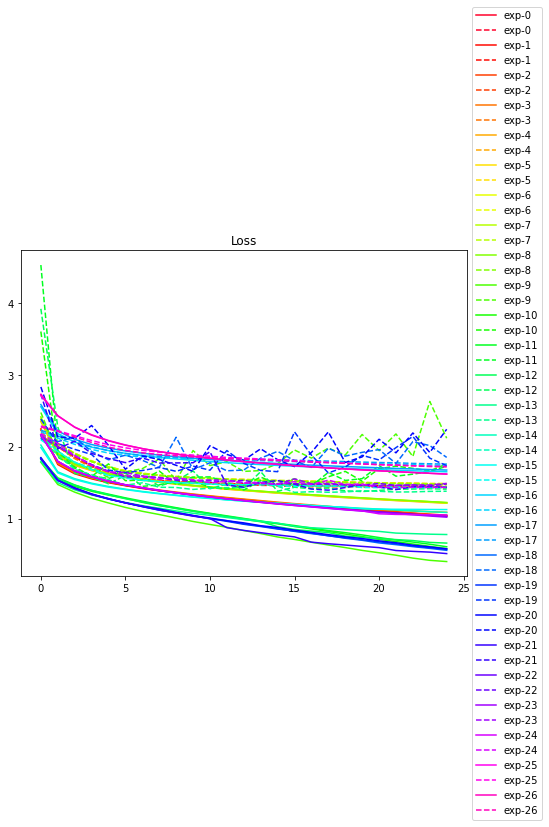

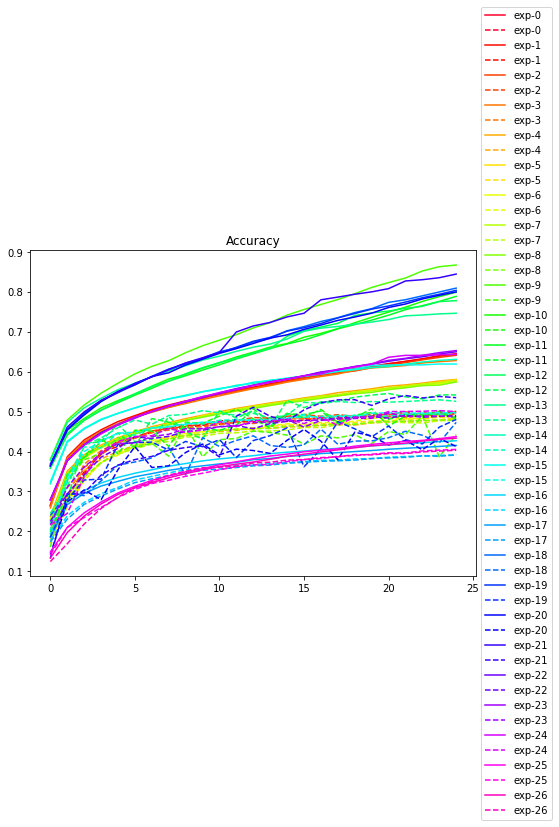

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()